# **Background of the study:**
Recommendation is an important part of Machine learning, where algorithom generate recommdations for users or consumers using existing pattern and insight from data. We already see different implications of recommendations in our everyday life, for example in youtube you get recommendations for similar movie or songs, if system learns viewers have preference for certain kind of movies or songs. Likewise, consumers also get recommendations for similar or related product by Amazon, Ebay, Wayfair, as consumers search for something or buy something. In this project, different recommendations systems are applied to get recommendations as well as a comperative analysis is also done among these recommendation systems.

In this project Popularity based recommendation, Model based collaborative filtering like SVD, Item-Item based collaborative filtering and User-User based collaborative filtering are applied on Amazon Musical Instrument Dataset.

# **Data Dictionary:**

- user_id - Every user has a unique ID 
- prod_id - Every product has a unique ID
- rating - Users have rated the product. In this dataset, we will use only this numerical dataset to build our recommendation. The other two columns are object data

### Import Required Libraries

In [ ]:
#Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded=files.upload()

Saving ratings_Musical_Instruments.csv to ratings_Musical_Instruments (1).csv


### Loading datasets and Exploratory Data Analysis

In [ ]:
#Importing the dataset
df_c = pd.read_csv('/content/drive/MyDrive/ratings_Musical_Instruments.csv', header=None)


In [ ]:
#Dropping the product name column and copying the dataset
df_c.columns = ['user_id', 'prod_id', 'rating', 'prod_name']
df_c = df_c.drop('prod_name', axis=1, )
df= df_c.copy(deep=True)

In [ ]:
# checking the first rows of the dataset
df.head()

,user_id,prod_id,rating
0,A1YS9MDZP93857,0006428320,3.0
1,A3TS466QBAWB9D,0014072149,5.0
2,A3BUDYITWUSIS7,0041291905,5.0
3,A19K10Z0D2NTZK,0041913574,5.0
4,A14X336IB4JD89,0201891859,1.0


- 

In [ ]:
# Checking the number of rows and columns
df.shape

(500176, 3)

- There are 500176 rows and 3 columns

In [ ]:
#Checking Data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500176 entries, 0 to 500175
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  500176 non-null  object 
 1   prod_id  500176 non-null  object 
 2   rating   500176 non-null  float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


In [ ]:
# Checking for missing values
df.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

- There are no missing values

In [ ]:
# Summary statistics of 'rating' variable, as this is only numerical variable
df[['rating']].describe()

,rating
count,500176.000000
mean,4.244350
std,1.203374
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [ ]:
# finding minimum and maximum ratings 

df['rating'].min()

1.0

In [ ]:
df['rating'].max()

5.0

### Ratings are on scale of 1 - 5

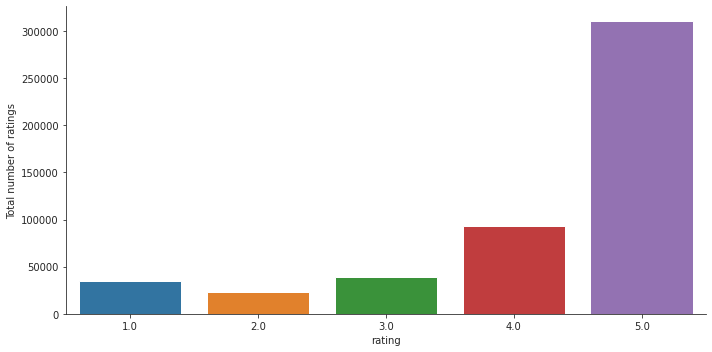

In [ ]:
#checking the distributions of ratings
with sns.axes_style('ticks'):
  g = sns.factorplot("rating", data=df, aspect=2.0, kind='count')
  g.set_ylabels('Total number of ratings')

- Most of the users have postively rated

In [ ]:
# Number of unique user id and product id
df['user_id'].nunique()


339231

In [ ]:
df['prod_id'].nunique()

83046

- There are 339231 user ID and and 83046 unique product ID in the data. That means, some users have rated muliple times.

Taking a  subset of dataset to make it less sparse/more dense. For example - we will keep only those who have rated 50 times or more. Because, in rating dataset, sparsity is a challenge to face, where most of the values is with 0.

In [ ]:
# Top 10 users based on rating
top_users = df.groupby('user_id').size().sort_values(ascending=False)[:10]
top_users

user_id
A2PAD826IH1HFE    483
A2AIMXT9PLAM12    463
A2NYK9KWFMJV4Y    454
A33GGROUQRQZS     154
A2PR6NXG0PA3KY    135
ALAJL3S09HBS7     126
AGLHCU1KX96DZ     118
A21VR7M8O55EF6    114
A16CZRQL23NOIW    113
AKYDGCKCY7H9F     110
dtype: int64

- They are the top users who rated most frequently. The first user A2PAD826IH1HFE has rated 483 times

In [ ]:
#Setting the minimum requirments as 50 to be considered.
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [ ]:
#Number of unique users and items based on our previous criteria
print('Number of users who have rated 50 or more items =', len(df_final))
print('Number of unique USERS in final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in final data = ', df_final['prod_id'].nunique())

Number of users who have rated 50 or more items = 5985
Number of unique USERS in final data =  64
Number of unique ITEMS in final data =  5208


In [ ]:
#Calculating density of rating matrix
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

Shape of final_ratings_matrix:  (64, 5208)
given_num_of_ratings =  5985
possible_num_of_ratings =  333312
density: 1.80%


In [ ]:
#Checking the first five rows
final_ratings_matrix.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
user_id,,,,,,,,,,,,,,,,,,,,,
A15TYOEWBQYF0X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16CZRQL23NOIW,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16ZKUFXHXQFW5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19T4IHJU5CZOE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ANRKHR4QWXJU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Transpose version of  Matrix with one row per 'Product' and one column per 'user' for Item-based CF
final_ratings_matrix_T = final_ratings_matrix.transpose()
final_ratings_matrix_T.head()

user_id,A15TYOEWBQYF0X,A16CZRQL23NOIW,A16ZKUFXHXQFW5,A19T4IHJU5CZOE,A1ANRKHR4QWXJU,A1F89OE7BAM7EL,A1GMWTGXW682GB,A1HV1D5EKO45GA,A1JUKS0DSO2XZG,A1KGQ62P8SRBRH,...,AJK15Q9JOEHRH,AKYDGCKCY7H9F,AL3G7RTXMGLDQ,ALAJL3S09HBS7,ALHC64J88LVWO,AQ4B80F0JSBNI,AQ6J4B5WLGRJ5,AQ9T9A5WJXVA9,AZC562U18BK2S,AZMHABTPXVLG3
prod_id,,,,,,,,,,,,,,,,,,,,,
0739059114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1417030321,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B00000079L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0000008BR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
B0000008D7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0


In [ ]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=0)

print(train_data.head(5))

               user_id     prod_id  rating
147509  A3JV7KL1ECLZB8  B000GW8BBW     5.0
84080   A3SMT15X2QVUR8  B0002IP47O     5.0
17263   A1UBBIDQTDDF79  B00007EEKG     5.0
130246  A3JV7KL1ECLZB8  B000E0LBA4     5.0
148714    A6FIAB28IS79  B000H7O9ZI     4.0


In [ ]:
train_data.shape

(4189, 3)

In [ ]:
test_data.shape

(1796, 3)

- There are 11830 rows in train and 5070 rows in test data

# **Popularity Based Recommender model - Non-personalised**

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_score = train_data.groupby('prod_id').agg({'user_id': 'count'}).reset_index()
train_data_score.rename(columns = {'user_id': 'score'},inplace=True)
train_data_score.head()

,prod_id,score
0,0739059114,1
1,1417030321,1
2,B00000079L,1
3,B0000008D7,1
4,B0000008KR,1


In [ ]:
#sorting the products based on recommendation score 
train_data_sort = train_data_score.sort_values(['score', 'prod_id'], ascending = [0,1]) 
      
#Generating a recommendation rank based upon score 
train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#getting the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

,prod_id,score,Rank
805,B0002F7K7Y,8,1.0
2650,B003RCFCXI,5,2.0
219,B00004SYFQ,4,3.0
566,B0002CZV82,4,4.0
654,B0002E1G5C,4,5.0


In [ ]:
# Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['user_id'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [ ]:
#Finding recommendations for the users
find_recom = [20,125,200, 350, 510] 
for i in find_recom:
    print("Here is the recommendation for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

Here is the recommendation for the userId: 20

      user_id     prod_id  score  Rank
805        20  B0002F7K7Y      8   1.0
2650       20  B003RCFCXI      5   2.0
219        20  B00004SYFQ      4   3.0
566        20  B0002CZV82      4   4.0
654        20  B0002E1G5C      4   5.0


Here is the recommendation for the userId: 125

      user_id     prod_id  score  Rank
805       125  B0002F7K7Y      8   1.0
2650      125  B003RCFCXI      5   2.0
219       125  B00004SYFQ      4   3.0
566       125  B0002CZV82      4   4.0
654       125  B0002E1G5C      4   5.0


Here is the recommendation for the userId: 200

      user_id     prod_id  score  Rank
805       200  B0002F7K7Y      8   1.0
2650      200  B003RCFCXI      5   2.0
219       200  B00004SYFQ      4   3.0
566       200  B0002CZV82      4   4.0
654       200  B0002E1G5C      4   5.0


Here is the recommendation for the userId: 350

      user_id     prod_id  score  Rank
805       350  B0002F7K7Y      8   1.0
2650      350  B003RCFC

- We have generated recommendations for users using popularity based recommendation model. However, from 5 users recommendations, we observe all recommendations are same, as because popularity based recommendation model does not take the users charecteristics or any thing in condsideration. It is completely universe. Recommendation is not personalized to a particular user.

# **Collaborative Filtering Model based Recommendation**

# **Model Based Collaborative Filtering: Singular Value Decomposition(SVD)**

In [ ]:
#Concating the train and test dataset to apply SVD
df_CF = pd.concat([train_data, test_data]).reset_index()
df_CF.tail()

,index,user_id,prod_id,rating
5980,265865,A2X64F7DOMZO23,B00281TGJA,5.0
5981,8441,AQ6J4B5WLGRJ5,B00004VCQ8,5.0
5982,207153,A2EDYSY4M8TESS,B0016MFJCA,4.0
5983,277384,A2AIMXT9PLAM12,B002JP9I66,2.0
5984,334401,AGLHCU1KX96DZ,B003X859OS,5.0


In [ ]:
#User-based Collaborative Filtering
# Matrix with row per 'user' and column per 'item' 
pivot_df = df_CF.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print(pivot_df.shape)
pivot_df.head()

(64, 5208)


prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
user_id,,,,,,,,,,,,,,,,,,,,,
A15TYOEWBQYF0X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16CZRQL23NOIW,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16ZKUFXHXQFW5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19T4IHJU5CZOE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ANRKHR4QWXJU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Creating a dataframe with prod_id and user_id
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC,user_index
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [ ]:
#Setting user_index
pivot_df.set_index(['user_index'], inplace=True)

# Actual ratings given by users
pivot_df.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from scipy.sparse.linalg import svds
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 50)
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
0,-0.008714,0.000590,0.000031,-0.000015,0.000006,0.000006,0.000019,-0.001105,0.002068,-0.014498,...,-0.000663,-0.000015,-0.000221,0.000408,-0.000956,0.000186,0.004235,-0.000956,0.000430,-0.000956
1,0.000655,4.001827,0.000659,-0.000156,-0.000342,-0.000342,0.000395,-0.006851,0.003551,0.006579,...,-0.004110,-0.000156,-0.001370,0.004285,0.000116,-0.001740,0.063327,0.000116,-0.000132,0.000116
2,0.000087,0.000001,0.000008,-0.000004,-0.000002,-0.000002,0.000005,-0.000130,0.000016,0.000544,...,-0.000078,-0.000004,-0.000026,0.000106,-0.000247,0.000152,0.000834,-0.000247,0.000820,-0.000247
3,-0.003159,-0.016927,0.006983,0.002672,0.002900,0.002900,0.004190,0.026962,-0.208275,-0.089406,...,0.016177,0.002672,0.005392,0.009832,0.000157,0.001388,1.205622,0.000157,0.000787,0.000157
4,0.000014,0.000238,0.000114,0.000017,-0.000126,-0.000126,0.000068,-0.000862,-0.000048,0.000525,...,-0.000517,0.000017,-0.000172,0.000614,0.000008,-0.000246,0.011862,0.000008,-0.000009,0.000008


In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
      
    user_idx = userID-1 # index starts at 0
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions

    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

**Generating Recommendations for several users using SVD**

In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 20
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 20):

                   user_ratings  user_predictions
Recommended Items                                
B000PGTICA                  0.0          0.031680
B0012XDFPG                  0.0          0.031680
B001F1YBOY                  0.0          0.023996
B0009VKRW6                  0.0          0.021945
B0017SETZG                  0.0          0.021325


In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 12
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 12):

                   user_ratings  user_predictions
Recommended Items                                
B007TKL7IS                  0.0          0.326806
B005SN730E                  0.0          0.326806
B005FUWTRC                  0.0          0.326806
B005DUR7U8                  0.0          0.326806
B003N7BCFE                  0.0          0.326806


In [ ]:
#Enter 'userID' and 'num_recommendations' for the user #
userID = 33
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 33):

                   user_ratings  user_predictions
Recommended Items                                
B00013D46S                  0.0          2.862705
B0000B1A5C                  0.0          2.862705
B003TUG3UO                  0.0          2.862705
B0042LJTQO                  0.0          1.636025
B006XOBFTM                  0.0          1.636025


- Uisng SVD we have generated recommedations for three users. and they have differerent kind of recommednations for diferent users. Unlike Popularity based recommendation, SVD generates person specific recommedation

#### Evaluation of Model-based Collaborative Filtering (SVD)

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
user_id,,,,,,,,,,,,,,,,,,,,,
A15TYOEWBQYF0X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16CZRQL23NOIW,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A16ZKUFXHXQFW5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A19T4IHJU5CZOE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1ANRKHR4QWXJU,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

prod_id
0739059114    0.078125
1417030321    0.140625
B00000079L    0.078125
B0000008BR    0.078125
B0000008D7    0.062500
dtype: float64

In [ ]:
# Predicted ratings 
preds_df.head()

prod_id,0739059114,1417030321,B00000079L,B0000008BR,B0000008D7,B0000008KR,B000000A4C,B000000A4H,B000000A61,B000000A6C,...,B00JDB4C42,B00JDCZSN0,B00JJ9DYE2,B00JL1BHMO,B00JL760E8,B00JLDTA0S,B00JR82FNQ,B00K17YFBW,B00K9XF6JS,B00KWIMAGC
0,-0.008714,0.000590,0.000031,-0.000015,0.000006,0.000006,0.000019,-0.001105,0.002068,-0.014498,...,-0.000663,-0.000015,-0.000221,0.000408,-0.000956,0.000186,0.004235,-0.000956,0.000430,-0.000956
1,0.000655,4.001827,0.000659,-0.000156,-0.000342,-0.000342,0.000395,-0.006851,0.003551,0.006579,...,-0.004110,-0.000156,-0.001370,0.004285,0.000116,-0.001740,0.063327,0.000116,-0.000132,0.000116
2,0.000087,0.000001,0.000008,-0.000004,-0.000002,-0.000002,0.000005,-0.000130,0.000016,0.000544,...,-0.000078,-0.000004,-0.000026,0.000106,-0.000247,0.000152,0.000834,-0.000247,0.000820,-0.000247
3,-0.003159,-0.016927,0.006983,0.002672,0.002900,0.002900,0.004190,0.026962,-0.208275,-0.089406,...,0.016177,0.002672,0.005392,0.009832,0.000157,0.001388,1.205622,0.000157,0.000787,0.000157
4,0.000014,0.000238,0.000114,0.000017,-0.000126,-0.000126,0.000068,-0.000862,-0.000048,0.000525,...,-0.000517,0.000017,-0.000172,0.000614,0.000008,-0.000246,0.011862,0.000008,-0.000009,0.000008


In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

prod_id
0739059114    0.085281
1417030321    0.140494
B00000079L    0.078333
B0000008BR    0.081078
B0000008D7    0.006238
dtype: float64

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(5208, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
prod_id,,,
0739059114,0.078125,0.085281,0
1417030321,0.140625,0.140494,1
B00000079L,0.078125,0.078333,2
B0000008BR,0.078125,0.081078,3
B0000008D7,0.062500,0.006238,4


In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.01628 



# **Top 5 recommendations**

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 35
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 35):

                   user_ratings  user_predictions
Recommended Items                                
B001CBW1I0                  0.0          0.227742
B0030U1U4M                  0.0          0.227742
B000001B19                  0.0          0.227742
B00CJGFPAI                  0.0          0.227742
B004SC8XR8                  0.0          0.227742


In [ ]:
df_final

,user_id,prod_id,rating
241,A396ELNTQDFYPO,0739059114,5.0
1181,A328S9RN3U5M68,1417030321,5.0
1207,A16CZRQL23NOIW,1417030321,4.0
2196,A2AIMXT9PLAM12,B00000079L,5.0
2211,A2U49LUUY4IKQQ,B0000008BR,5.0
...,...,...,...
499709,A1JUKS0DSO2XZG,B00JLDTA0S,5.0
499811,A70WPHE33U5B,B00JR82FNQ,5.0
499937,A2NYK9KWFMJV4Y,B00K17YFBW,5.0
500059,A2EDYSY4M8TESS,B00K9XF6JS,5.0


## **Item-Item Based Collaborative Model**

In [ ]:
#Installing surprise library to conduct item-item and user-user collaborative model
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Importing the modules from surprise
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import reader
from surprise.model_selection import train_test_split

In [ ]:
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=.15)


In [ ]:
#instantiating the model for item-item cf by defining user_based:False
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo.fit(trainset)

- Pearson is used to measure the similarity and 50 neighbors will be considered which is defined by k value=50

In [ ]:
# applying the model on test dataset
test_pred = algo.test(testset)

In [ ]:
test_pred

[Prediction(uid='774', iid='172', r_ui=3.0, est=2.8756351270351836, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='704', iid='494', r_ui=5.0, est=3.908045518549651, details={'actual_k': 39, 'was_impossible': False}),
 Prediction(uid='143', iid='333', r_ui=5.0, est=4.0218889321451545, details={'actual_k': 12, 'was_impossible': False}),
 Prediction(uid='285', iid='100', r_ui=4.0, est=4.172960241150551, details={'actual_k': 17, 'was_impossible': False}),
 Prediction(uid='717', iid='597', r_ui=4.0, est=3.556538054882288, details={'actual_k': 41, 'was_impossible': False}),
 Prediction(uid='182', iid='864', r_ui=4.0, est=3.2940658747028304, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid='864', iid='195', r_ui=4.0, est=4.326719886787512, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='387', iid='180', r_ui=4.0, est=4.176141286158135, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='405', iid='842', r_ui=5.0, es

- From above we observe the gap between actual rating and estimated rating, for example user id 882 the rating is 4 and estimated 3.89

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

Item-based Model : Test Set
RMSE: 0.9195


0.9194714710632349

# **User-User Based Recommendation Model**

In [ ]:
# Use user_based true/false to switch between user-based or item-based collaborative filtering
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [ ]:
test_pred1 = algo.test(testset)

In [ ]:
test_pred1

[Prediction(uid='774', iid='172', r_ui=3.0, est=2.712383937707201, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='704', iid='494', r_ui=5.0, est=3.987373057981755, details={'actual_k': 28, 'was_impossible': False}),
 Prediction(uid='143', iid='333', r_ui=5.0, est=4.2014580607298715, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='285', iid='100', r_ui=4.0, est=4.6660041291439605, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='717', iid='597', r_ui=4.0, est=3.385974538740375, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='182', iid='864', r_ui=4.0, est=3.5538249722246427, details={'actual_k': 29, 'was_impossible': False}),
 Prediction(uid='864', iid='195', r_ui=4.0, est=4.313085966854183, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='387', iid='180', r_ui=4.0, est=4.115286572767272, details={'actual_k': 50, 'was_impossible': False}),
 Prediction(uid='405', iid='842', r_ui=5.0, e

- There is no greysheep problem, as there is no was_impossible=True
- actual k means how many neighbor came up with  positive rating with this particular product, similarity is more than 0.5 then it is considered positive correlation

In [ ]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred1, verbose=True)

Item-based Model : Test Set
RMSE: 0.9367


0.9367482156831457

In [ ]:
# we can now query for specific predicions
uid = str(196)  # raw user id
iid = str(302)  # raw item id

In [ ]:
# get a prediction for specific users and items.
pred = algo.predict(uid, iid, verbose=True)

user: 196        item: 302        r_ui = None   est = 4.07   {'actual_k': 50, 'was_impossible': False}


# **Findings and Comperative picture**

From the overall analysis, also by comparing the actual rating and predicted rating, the recommedation systems have overall predicted a satisfactory rating. If we directly compare two different major types of rating, then popularity based recommendation is non-personalized method, which generate recommendations based on total score point and recommendations remain same throughout all users. Whereas, collaborative filtering based model uses the past information of the users or about the item, and able to generate person specific recommendation, which is a big advantage and realistic in comparison of popularity based recommendation. 
When we futher compair various collaborative filtering model, then overall SIngle Value Decomposition or model based cf is more reliable in this project than item-item or user-user based model. Specially user-user based model limited by the variations of human being. Two persons might be different though they have give similar rating for two products or two movies. Item-Item cf also sometimes can be non realistic, as it is to conclude simply a product which got higher rating, will be liked by one user as because it is got higher score. There might be no demand for one product by a specific user.